# Week4授業課題 信用情報を学習しよう

## 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

In [1]:
# ライブラリのインポート
import numpy as np

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
import pandas as pd

pd.set_option('display.max_rows', 500)

In [13]:
# train.csvの読み込み
df_train = pd.read_csv("application_train.csv")
df_train.shape

(307511, 122)

In [14]:
# test.csvの読み込み
df_test = pd.read_csv("application_test.csv")
df_test.shape

(48744, 121)

In [15]:
#学習データの情報表示
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [16]:
#特徴量の要約統計量の表示
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [17]:
# 欠損値があるデータをカウント
Total = df_train.isnull().sum()
# 欠損値の割合を算出
missing_rate = Total / len(df_train)

#　テーブルにカウントした欠損値と割合を格納
missing_table = pd.DataFrame({
    'Total': Total,
    'missing_rate': missing_rate
})

#欠損値の割合が大きい順にソートする
missing_table.sort_values(by='missing_rate', ascending=False)

,Total,missing_rate
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550
LIVINGAPARTMENTS_MEDI,210199,0.683550


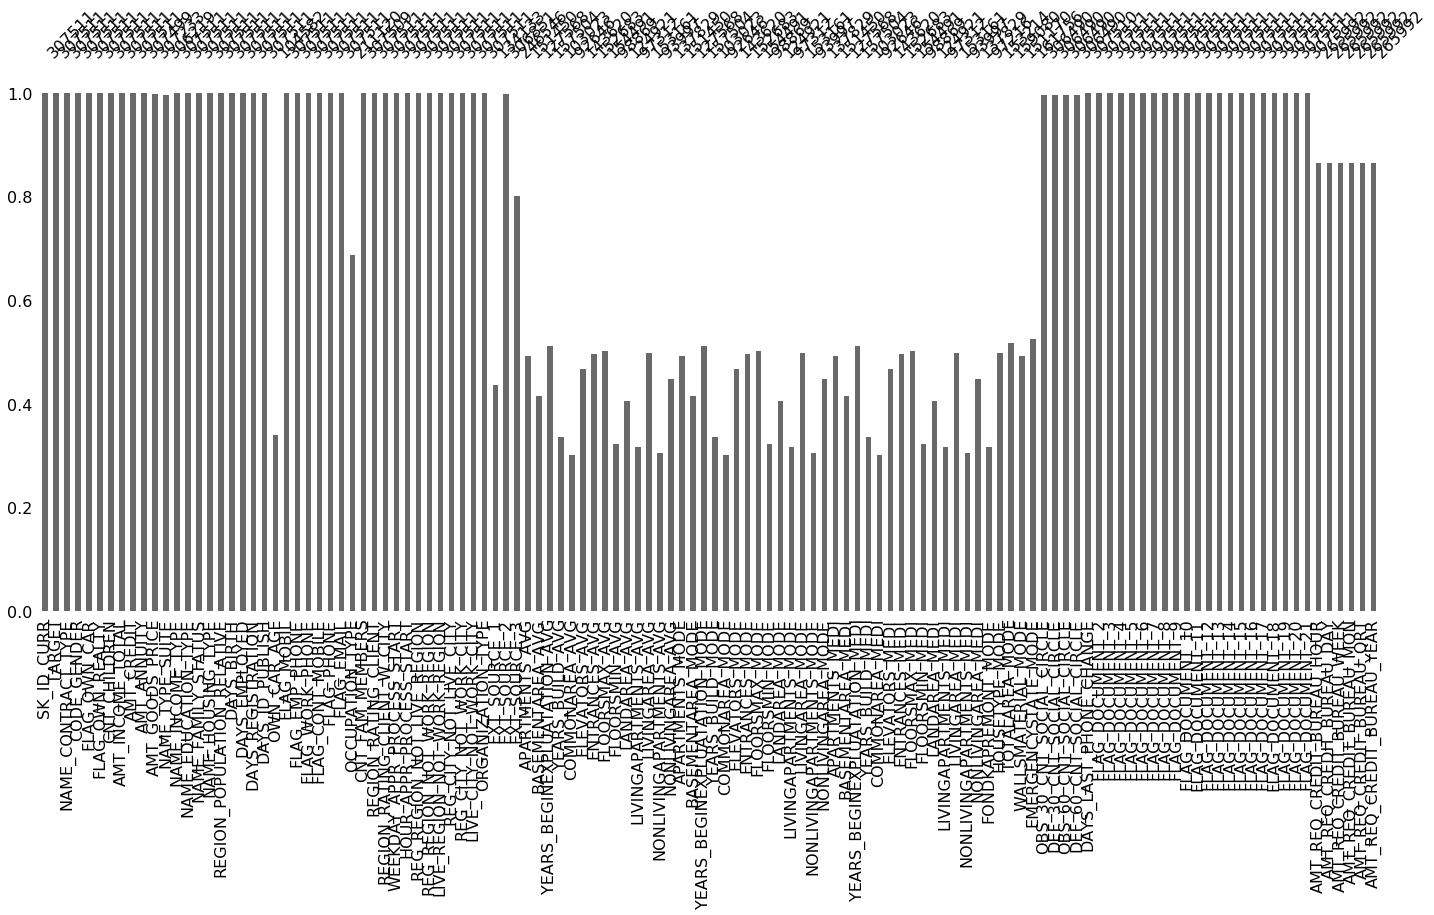

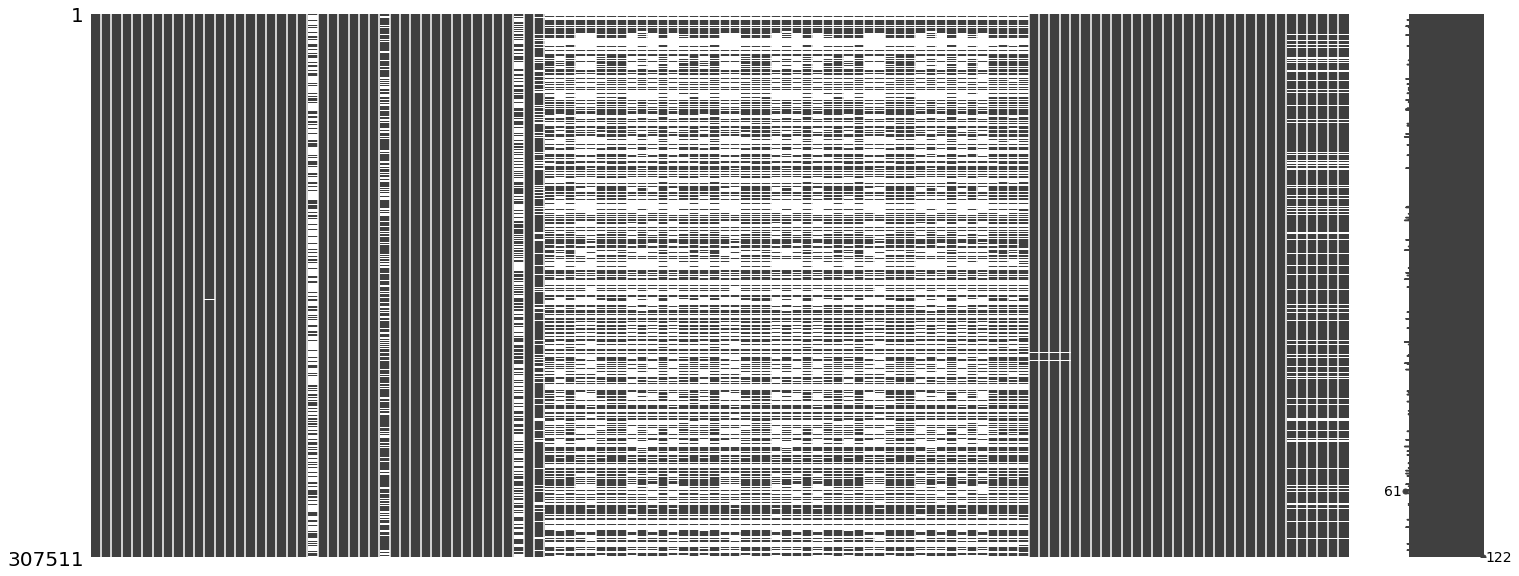

In [18]:
#missingnoモジュールのインポート
import missingno as msno

#欠損値の有無をバーとして表示
#バーが1.0に満たない特徴量に欠損値が発生していると確認できる
msno.bar(df_train)
plt.show()
msno.matrix(df_train)
plt.show()

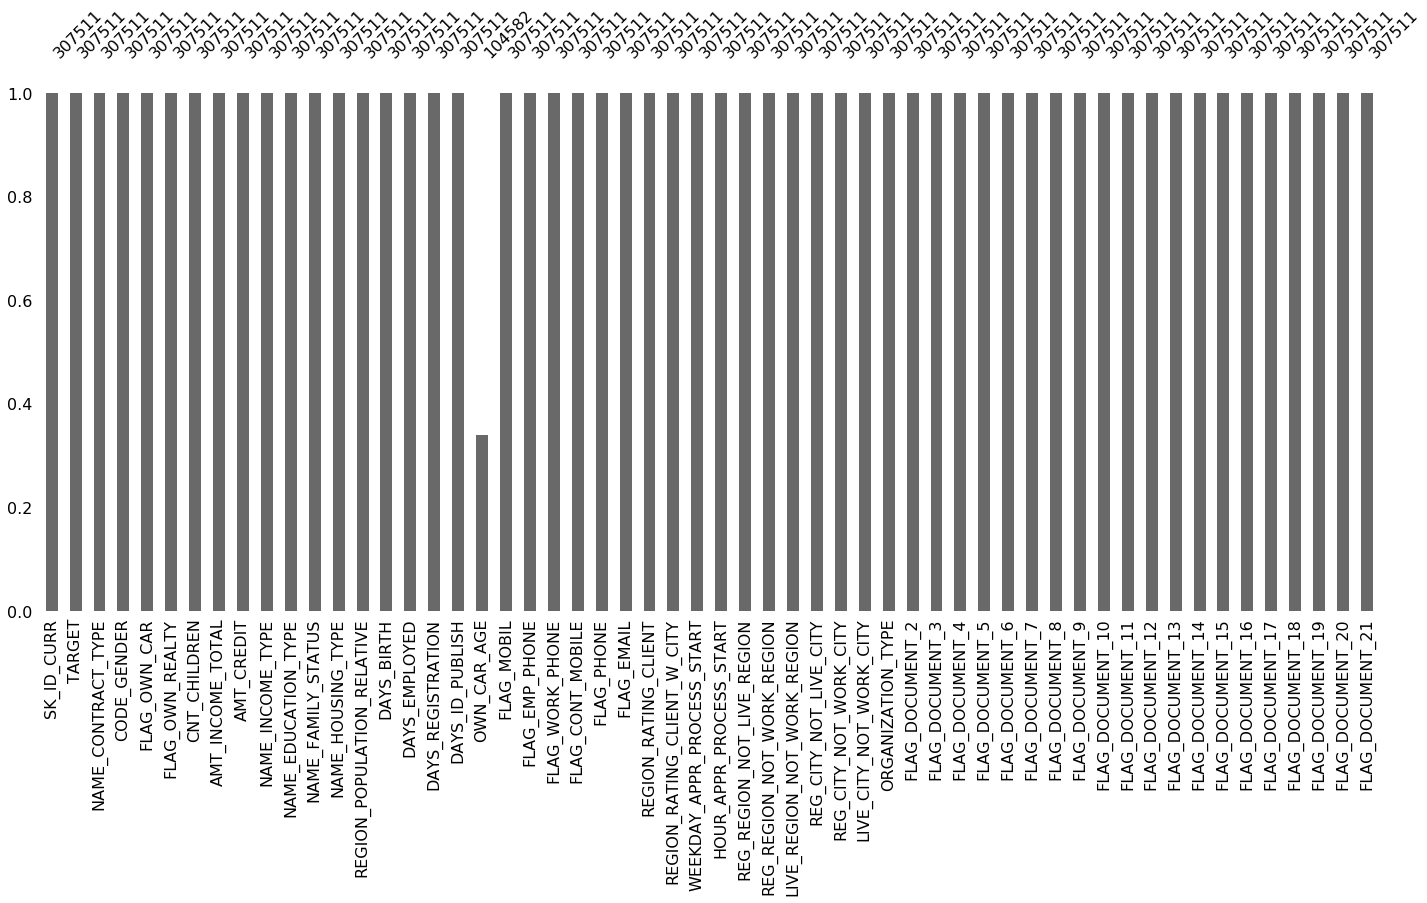

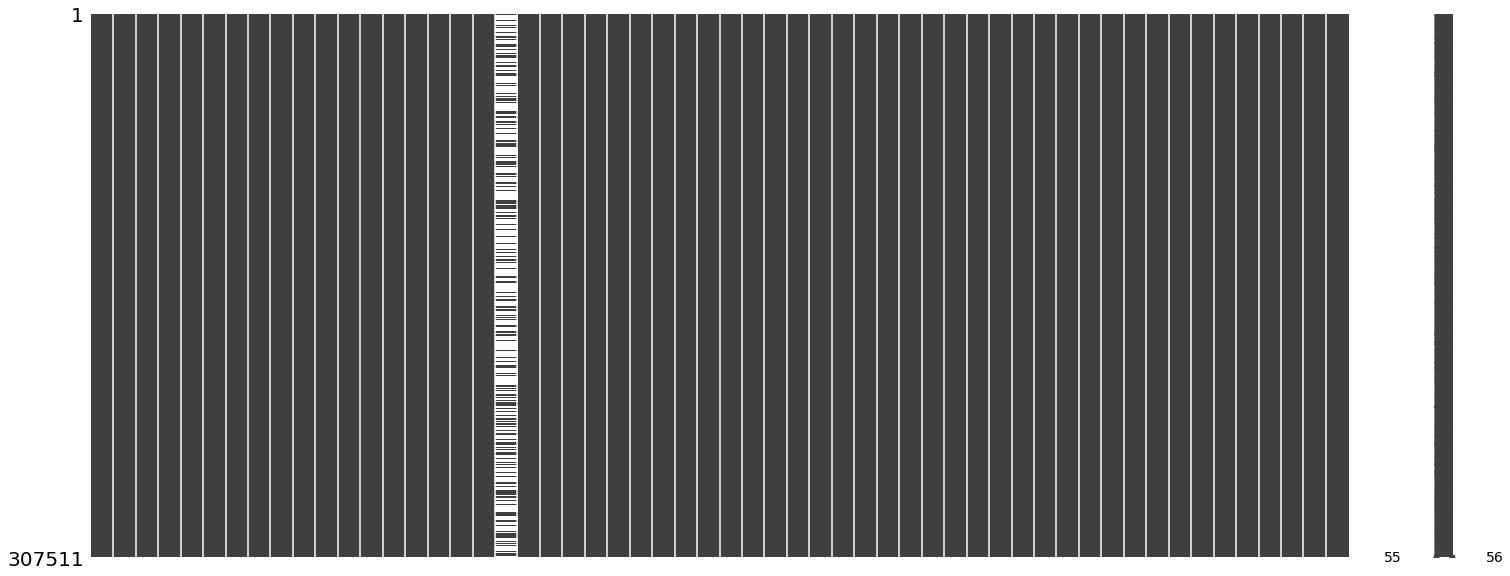

In [19]:
#  学習データより特徴量選択(欠損値補完をする"OWN_CAR_AGE"以外は全てドロップする)
df_train_select = df_train.drop(columns=[
    'COMMONAREA_MEDI', 
    'COMMONAREA_AVG', 
    'COMMONAREA_MODE', 
    'NONLIVINGAPARTMENTS_MODE', 
    'NONLIVINGAPARTMENTS_AVG', 
    'NONLIVINGAPARTMENTS_MEDI', 
    'FONDKAPREMONT_MODE', 
    'LIVINGAPARTMENTS_MODE', 
    'LIVINGAPARTMENTS_AVG', 
    'LIVINGAPARTMENTS_MEDI', 
    'FLOORSMIN_AVG', 
    'FLOORSMIN_MODE', 
    'FLOORSMIN_MEDI', 
    'YEARS_BUILD_MEDI', 
    'YEARS_BUILD_MODE', 
    'YEARS_BUILD_AVG', 
    'LANDAREA_MEDI', 
    'LANDAREA_MODE', 
    'LANDAREA_AVG', 
    'BASEMENTAREA_MEDI', 
    'BASEMENTAREA_AVG', 
    'BASEMENTAREA_MODE', 
    'NONLIVINGAREA_MODE', 
    'NONLIVINGAREA_AVG', 
    'NONLIVINGAREA_MEDI', 
    'ELEVATORS_MEDI', 
    'ELEVATORS_AVG', 
    'ELEVATORS_MODE', 
    'WALLSMATERIAL_MODE', 
    'APARTMENTS_MEDI', 
    'APARTMENTS_AVG', 
    'APARTMENTS_MODE', 
    'ENTRANCES_MEDI', 
    'ENTRANCES_AVG', 
    'ENTRANCES_MODE', 
    'LIVINGAREA_AVG', 
    'LIVINGAREA_MODE', 
    'LIVINGAREA_MEDI', 
    'HOUSETYPE_MODE', 
    'FLOORSMAX_MODE', 
    'FLOORSMAX_MEDI', 
    'FLOORSMAX_AVG', 
    'YEARS_BEGINEXPLUATATION_MODE', 
    'YEARS_BEGINEXPLUATATION_MEDI', 
    'YEARS_BEGINEXPLUATATION_AVG', 
    'TOTALAREA_MODE', 
    'EMERGENCYSTATE_MODE', 
    'OCCUPATION_TYPE',
    'EXT_SOURCE_1', 
    'OCCUPATION_TYPE', 
    'EXT_SOURCE_3', 
    'AMT_REQ_CREDIT_BUREAU_HOUR', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 
    'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 
    'AMT_REQ_CREDIT_BUREAU_QRT', 
    'AMT_REQ_CREDIT_BUREAU_YEAR', 
    'NAME_TYPE_SUITE', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE', 
    'EXT_SOURCE_2', 
    'AMT_GOODS_PRICE', 
    'AMT_ANNUITY', 
    'CNT_FAM_MEMBERS', 
    'DAYS_LAST_PHONE_CHANGE'], axis=1)

msno.bar(df_train_select)
plt.show()
msno.matrix(df_train_select)
plt.show()



In [20]:
#特徴量"OWN_CAR_AGE"のnanを補完(車非保有者がnanのため、0とする)
X_train = df_train_select
X_train["OWN_CAR_AGE"] = X_train["OWN_CAR_AGE"].fillna(0)

#数値データのみを抜き出す
X_train_numeric = X_train.select_dtypes(include=[np.number])

#目的変数の抜き出し
y_train = X_train_numeric.pop('TARGET')

# 訓練データの行列数確認
X_train_numeric.shape

(307511, 45)

In [21]:
# PCAで次元削減、ロジスティック回帰での分類(SVMでの分類は処理に時間がかかるため、断念。。)
estimators = [('pca', PCA()),
              ('lr', LogisticRegression())]

# グリッドリサーチでの探索パラメータ
parameters = {"pca__n_components" : range(2, 6),
              "lr__penalty" : ["l2", "l1"],
              'lr__C': np.logspace(0, 2, 10).tolist()
             }

# plを一つの分類器としてみなす
pl = Pipeline(estimators)

In [22]:
# 分類器を渡し、グリッドリサーチのインスタンス生成
clf = GridSearchCV(pl, parameters, n_jobs=-1)

# 優れたハイパーパラメーターを探索
clf.fit(X_train_numeric, y_train)

# ベストパラメータを出力
print('Best_estimator = {0}'.format(clf.best_params_))

/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best_estimator = {'lr__C': 1.0, 'lr__penalty': 'l2', 'pca__n_components': 2}


In [23]:
# auc算出
lr_auc = roc_auc_score(y_train, clf.decision_function(X_train_numeric))
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.5176675774448791


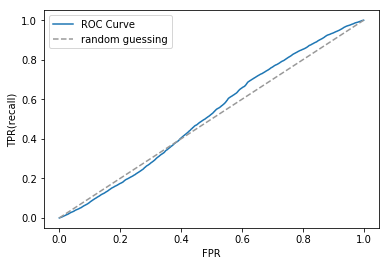

In [24]:
# ROCカーブを出力する
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, clf.decision_function(X_train_numeric))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color=(0.6,0.6,0.6), label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")


In [25]:
# testデータより特徴量選択(欠損値補完をする"OWN_CAR_AGE"以外は全てドロップする)
df_test_select = df_test.drop(columns=[
    'COMMONAREA_MEDI', 
    'COMMONAREA_AVG', 
    'COMMONAREA_MODE', 
    'NONLIVINGAPARTMENTS_MODE', 
    'NONLIVINGAPARTMENTS_AVG', 
    'NONLIVINGAPARTMENTS_MEDI', 
    'FONDKAPREMONT_MODE', 
    'LIVINGAPARTMENTS_MODE', 
    'LIVINGAPARTMENTS_AVG', 
    'LIVINGAPARTMENTS_MEDI', 
    'FLOORSMIN_AVG', 
    'FLOORSMIN_MODE', 
    'FLOORSMIN_MEDI', 
    'YEARS_BUILD_MEDI', 
    'YEARS_BUILD_MODE', 
    'YEARS_BUILD_AVG', 
    'LANDAREA_MEDI', 
    'LANDAREA_MODE', 
    'LANDAREA_AVG', 
    'BASEMENTAREA_MEDI', 
    'BASEMENTAREA_AVG', 
    'BASEMENTAREA_MODE', 
    'NONLIVINGAREA_MODE', 
    'NONLIVINGAREA_AVG', 
    'NONLIVINGAREA_MEDI', 
    'ELEVATORS_MEDI', 
    'ELEVATORS_AVG', 
    'ELEVATORS_MODE', 
    'WALLSMATERIAL_MODE', 
    'APARTMENTS_MEDI', 
    'APARTMENTS_AVG', 
    'APARTMENTS_MODE', 
    'ENTRANCES_MEDI', 
    'ENTRANCES_AVG', 
    'ENTRANCES_MODE', 
    'LIVINGAREA_AVG', 
    'LIVINGAREA_MODE', 
    'LIVINGAREA_MEDI', 
    'HOUSETYPE_MODE', 
    'FLOORSMAX_MODE', 
    'FLOORSMAX_MEDI', 
    'FLOORSMAX_AVG', 
    'YEARS_BEGINEXPLUATATION_MODE', 
    'YEARS_BEGINEXPLUATATION_MEDI', 
    'YEARS_BEGINEXPLUATATION_AVG', 
    'TOTALAREA_MODE', 
    'EMERGENCYSTATE_MODE', 
    'OCCUPATION_TYPE',
    'EXT_SOURCE_1', 
    'OCCUPATION_TYPE', 
    'EXT_SOURCE_3', 
    'AMT_REQ_CREDIT_BUREAU_HOUR', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 
    'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 
    'AMT_REQ_CREDIT_BUREAU_QRT', 
    'AMT_REQ_CREDIT_BUREAU_YEAR', 
    'NAME_TYPE_SUITE', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE', 
    'EXT_SOURCE_2', 
    'AMT_GOODS_PRICE', 
    'AMT_ANNUITY', 
    'CNT_FAM_MEMBERS', 
    'DAYS_LAST_PHONE_CHANGE'], axis=1)

#特徴量"OWN_CAR_AGE"のnanを補完(車非保有者がnanのため、0とする)
X_test = df_test_select
X_test["OWN_CAR_AGE"] = X_test["OWN_CAR_AGE"].fillna(0)

#数値データのみを抜き出す
X_test_numeric = X_test.select_dtypes(include=[np.number])

# 行列数確認
X_test_numeric.shape

(48744, 45)

In [26]:
# kaggle提出用のdataframeを作成する
submission = pd.DataFrame({'SK_ID_CURR': X_test_numeric['SK_ID_CURR'], 'TARGET': clf.predict_proba(X_test_numeric)[:, 1]})

In [27]:
# kaggle提出用のcsvファイルを作成する
submission.to_csv('HomeCreditDefaultRisk_20190402501.csv', index = False)

### kaggle提出
![kaggle](kaggle_submission_2019042501.png)

## 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）

このAUCを計算する関数を作成してください。

**※どの方法も上記のAUCと誤差が発生しているため、検討した方法を掲載**

### ①降順にソートされた予測スコア(scoer)と、それらの真のラベル(target)を順に処理して、各時点での True Positive, False Positive の増分から面積を求めて加算的に計算していく。  


<参考URL>  
[Area Under the ROC Curve (AUC) を実装する](https://takuti.me/note/auc/)

In [28]:
# スコアを降順にソートしたdataframeを作成する
target_score = pd.DataFrame({'target': y_train, 'score': clf.decision_function(X_train_numeric)}).sort_values('score', ascending=False)

In [29]:

def trapezoid(x1, x2, y1, y2):
    """与えられた長方形（台形）の面積を求める
    """
    base = abs(x1 - x2)
    height = (y1 + y2) / 2.
    return base * height


def auc(pred, label):
    """ソート済スコアとラベルのリストからAUCを求める
    """
    n = len(pred)

    a = 0.
    score_prev = float('-inf')
    fp = tp = 0
    fp_prev = tp_prev = 0

    # ソート済スコアとラベルのペアを逐次的にみていく
    for i in range(n):
        if pred[i] != score_prev:
            # True Positive (False Positive) の増分がつくる長方形の面積を加算
            a += trapezoid(fp, fp_prev, tp, tp_prev)

            score_prev = pred[i]
            fp_prev = fp
            tp_prev = tp

        # 現時点での True Positive, False Positive 数
        if label[i] == 1:
            tp += 1
        else:
            fp += 1

    a += trapezoid(fp, fp_prev, tp, tp_prev)

    # 最大面積で正規化
    return a / (tp * fp)

In [30]:
print('auc : {}'.format(auc(pred=target_score['score'], label=target_score['target'])))

auc : 0.5022368664732281


### ②ROC曲線上で横が(1/FPRの数)、高さがTPRとした長方形の合計を算出する

In [31]:
auc_socre = 0
for i in range(len(fpr)):
    auc_socre += tpr[i]*(1/len(fpr))
    
print('auc : {}'.format(auc_socre))

auc : 0.5013755987638068


### ③ROC曲線における積分を計算する

In [32]:
from scipy import integrate

y_integrate_trape = integrate.cumtrapz(tpr, fpr)  #台形則による数値積分計算

print('auc : {}'.format(y_integrate_trape[-1]))

auc : 0.5176675774448808


## 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。

汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

In [33]:
# EXT_SOURCRに着目する
X_train_EX = df_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# それぞれの欠損値に対しては平均代入法を利用する
X_train_EX["EXT_SOURCE_1"] = X_train_EX["EXT_SOURCE_1"].fillna(X_train_EX["EXT_SOURCE_1"].mean())
X_train_EX["EXT_SOURCE_2"] = X_train_EX["EXT_SOURCE_2"].fillna(X_train_EX["EXT_SOURCE_2"].mean())
X_train_EX["EXT_SOURCE_3"] = X_train_EX["EXT_SOURCE_3"].fillna(X_train_EX["EXT_SOURCE_3"].mean())

#numpyに変更
X_train_EX = X_train_EX.values

In [34]:
# PCAで次元削減、ロジスティック回帰での分類(SVMでの分類は処理に時間がかかるため、断念。。)
estimators = [('pca', PCA()),
              ('lr', LogisticRegression())]

# グリッドリサーチでの探索パラメータ
parameters = {"pca__n_components" : range(2, 3),
              "lr__penalty" : ["l2", "l1"],
              'lr__C': np.logspace(0, 2, 10).tolist()
             }

# plを一つの分類器としてみなす
pl = Pipeline(estimators)

In [35]:
# 分類器を渡し、グリッドリサーチのインスタンス生成
clf = GridSearchCV(pl, parameters, n_jobs=-1)

# 優れたハイパーパラメーターを探索
clf.fit(X_train_EX, y_train)

# ベストパラメータを出力
print('Best_estimator = {0}'.format(clf.best_params_))

/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yusuke-saruya/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best_estimator = {'lr__C': 1.0, 'lr__penalty': 'l2', 'pca__n_components': 2}


In [36]:
# auc算出
lr_auc = roc_auc_score(y_train, clf.decision_function(X_train_EX))
print("classifier_auc: {}".format(lr_auc))

classifier_auc: 0.7161616762673824


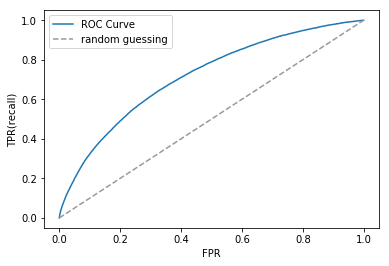

In [37]:
# ROCカーブを出力する
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, clf.decision_function(X_train_EX))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1], linestyle="--", color=(0.6,0.6,0.6), label="random guessing")
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc="best")


In [38]:
'''
testデータの処理
'''
# EXT_SOURCEに着目する
X_test_EX = df_test.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# それぞれの欠損値に対しては平均代入法を利用する
X_test_EX["EXT_SOURCE_1"] = X_test_EX["EXT_SOURCE_1"].fillna(X_test_EX["EXT_SOURCE_1"].mean())
X_test_EX["EXT_SOURCE_2"] = X_test_EX["EXT_SOURCE_2"].fillna(X_test_EX["EXT_SOURCE_2"].mean())
X_test_EX["EXT_SOURCE_3"] = X_test_EX["EXT_SOURCE_3"].fillna(X_test_EX["EXT_SOURCE_3"].mean())

#numpyに変更
X_test_EX = X_test_EX.values

In [39]:
# kaggle提出用のdataframeを作成する
submission2 = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': clf.predict_proba(X_test_EX)[:, 1]})

In [40]:
# kaggle提出用のcsvファイルを作成する
submission2.to_csv('HomeCreditDefaultRisk_20190402502.csv', index = False)

### kaggle提出2
![kaggle](kaggle_submission_2019042502.png)